# Summary

This notebook explores a hybrid approach for identifying dog breeds utilizing the feature extraction capabilities of Inception V3 and ResNet50 pretrained models. The model incorporates a classifier layer with a dropout rate of 0.7 to enhance generalization and mitigate overfitting.

## Methodology:

* **Preprocessing:** Input images undergo resizing to ensure uniform dimensions. Data augmentation techniques, such as horizontal and vertical flipping with a probability of 0.2, are applied to increase the diversity of training data and improve model generalization.
* **Feature Extraction:** Inception V3 and ResNet50 pretrained models are utilized to extract high-level features from the input images.
* **Classifier Layer:** The extracted features are fed into a classifier layer with a dropout rate of 0.7. 
* **Training:** The model is trained using a SGD optimization algorithm with a learning rate of 0.005, and Cross Entropy Loss. Training involves fine-tuning the classifier layer while keeping the parameters of the pretrained models frozen.
* **Evaluation:** The model's performance is assessed based on validation accuracy and loss metrics.


# Libraries

In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Visualization

import seaborn as sns
import matplotlib.pyplot as plt

# PyTorch

import torch as T
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import models
from torchvision import transforms

Configure GPU

In [2]:
device = T.device('cuda' if T.cuda.is_available() else 'cpu')

# Loading dataset

In [3]:
# Read csv file
train_data = pd.read_csv("/kaggle/input/dog-breed-identification/labels.csv")
# Train data shape
print(f"Train dataset shape: {train_data.shape}")
# Sample of the train_data DataFrame
train_data.head()

Train dataset shape: (10222, 2)


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


## Distribution of the breed classes

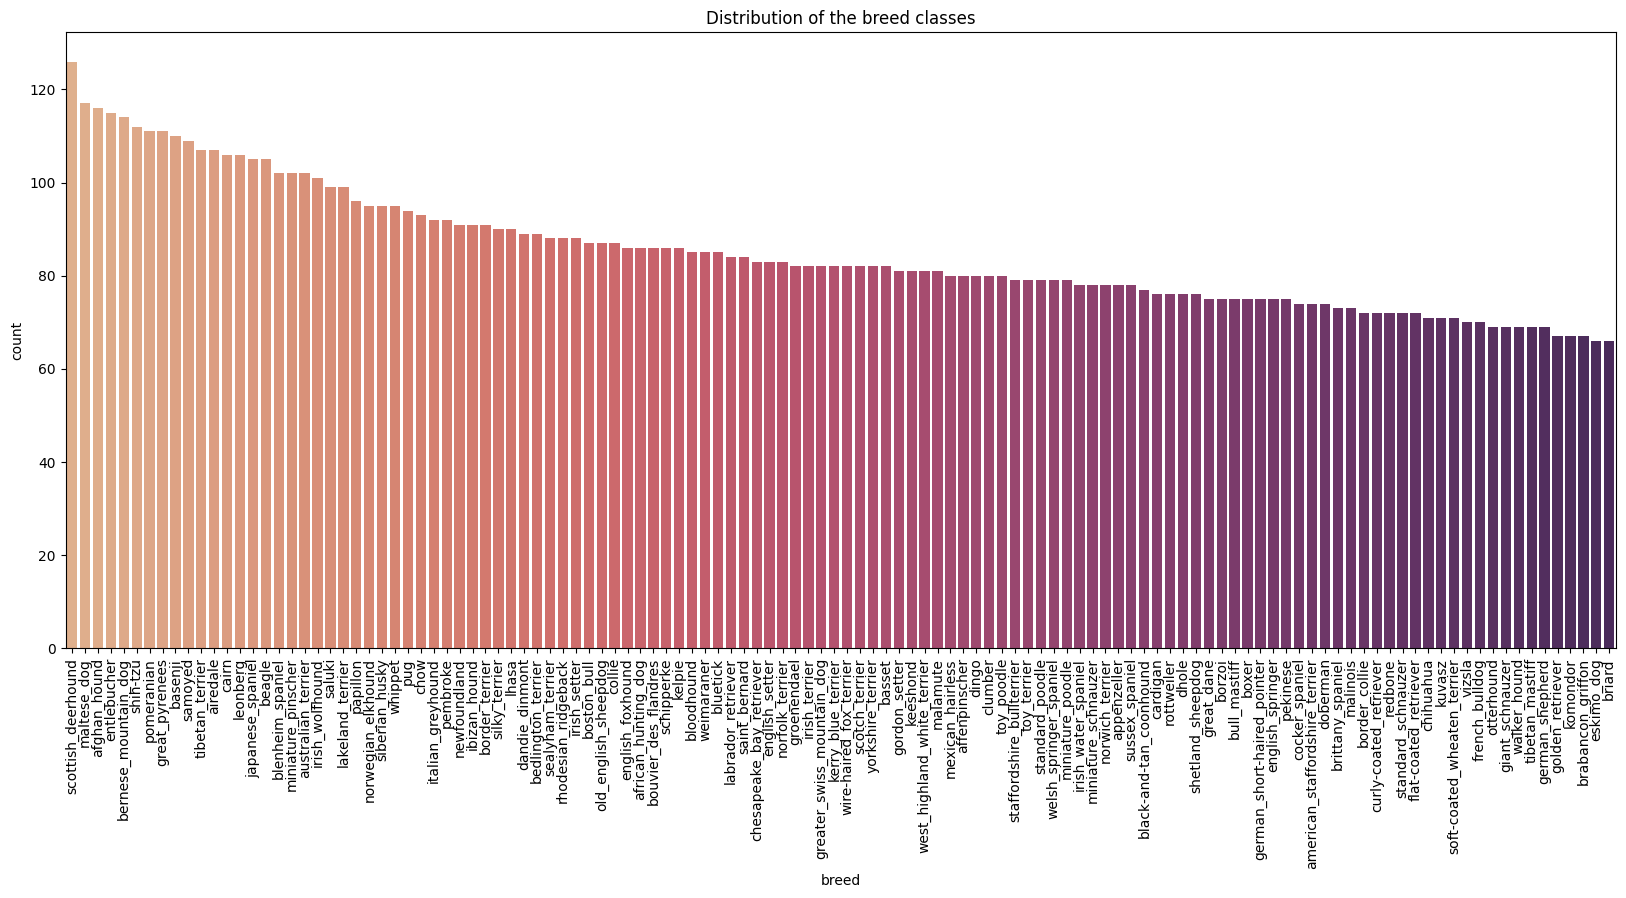

In [4]:
breed_classes = train_data.breed.value_counts().reset_index()
plt.figure(figsize=(20,8))
sns.barplot(breed_classes, x='breed', y='count', palette="flare")
plt.xticks(rotation=90)
plt.title("Distribution of the breed classes")
plt.show()

In [5]:
breed_classes['count'].describe()

count    120.000000
mean      85.183333
std       13.298122
min       66.000000
25%       75.000000
50%       82.000000
75%       91.250000
max      126.000000
Name: count, dtype: float64

Confirm the 120 dog breed classes

In [6]:
breed_classes['breed'].nunique()

120

# Label Encoding

In [7]:
le = LabelEncoder()
train_data.loc[:,'breed'] = le.fit_transform(train_data.loc[:,'breed']) 

In [8]:
train_data.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,19
1,001513dfcb2ffafc82cccf4d8bbaba97,37
2,001cdf01b096e06d78e9e5112d419397,85
3,00214f311d5d2247d5dfe4fe24b2303d,15
4,0021f9ceb3235effd7fcde7f7538ed62,49


# Dog Breed Dataset

In [9]:
class Dog_Breed_Dataset(Dataset):
    
    def __init__(self, df: pd.DataFrame, img_base_path: str, split: str, transforms = None):        
        self.df = df
        self.img_base_path = img_base_path
        self.split = split
        self.transforms = transforms
        
    def __getitem__(self, index):
        # Path of the image
        img_path = os.path.join(self.img_base_path + self.df.loc[index,'id'] + '.jpg')
        # Read the image
        img = Image.open(img_path)        
        # Perform the transformations
        if self.transforms:
            img = self.transforms(img)
        
        if self.split != 'test':
            y = self.df.loc[index, 'breed']                     
            return img, y
        else:            
            return img
    
    def __len__(self):
        return len(self.df)        

# Data Augmentation

In [10]:
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
test_transforms = transforms.Compose([
    transforms.Resize((224,224)),    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


## Get Data Loaders

### Split the dataset

In [11]:
train, val = train_test_split(train_data, test_size=0.2, random_state=42, stratify=train_data['breed'])

train = train.reset_index(drop=True)
val = val.reset_index(drop=True)

### Get the data loaders

In [12]:
train_dataset = Dog_Breed_Dataset(
    df=train,
    img_base_path='/kaggle/input/dog-breed-identification/train/',
    split='train',
    transforms=train_transforms
)
validation_dataset = Dog_Breed_Dataset(
    df=val,
    img_base_path='/kaggle/input/dog-breed-identification/train/',
    split='val',
    transforms=test_transforms
)

train_dl = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
validation_dl = DataLoader(validation_dataset, batch_size=64, shuffle=False, num_workers=4)    

In [13]:
print(f"Train data length: {len(train_dl.dataset)}, Validation data length: {len(validation_dl.dataset)}")

Train data length: 8177, Validation data length: 2045


# Training process

## Training function

In [14]:
def train_model(train_dl, val_dl, model, epochs=20):    
    
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []
    val_loss_history = []
    # Best validation accuracy
    best_val_loss = 1_000_000.0    
    # Get initial weights
    weights = model.get_weights()
    
    for epoch in range(epochs):
        print("="*20, "Epoch: ", str(epoch), "="*20)
        
        train_correct_pred = 0
        val_correct_pred = 0
        train_acc = 0
        val_acc = 0
        train_loss = 0
        val_loss = 0
        
        # Set to training mode
        model.train()
        
        for x, y in train_dl:               
            # Convert data to Tensor            
            x = x.clone().detach().to(device).requires_grad_(True)
            y = y.clone().detach().long().to(device)
            # Reset gradients
            model.optim.zero_grad()
            # Predict
            preds = model(x)            
            
            # Compute the loss            
            loss = model.criterion(preds,y)            
            
            # Compute the gradients            
            loss.backward()
            # Update weights
            model.optim.step()
            # Count the correct predictions
            preds = T.argmax(preds, dim=1)           
            train_correct_pred += (preds.long().unsqueeze(1) == y.unsqueeze(1)).sum().item()
            
            train_loss += loss.item()           
        
        train_acc = train_correct_pred / len(train_dl.dataset)
        
        train_acc_history.append(train_acc)
               
        train_loss_history.append(train_loss)
        
        # Switch to evaluation mode
        model.eval()        
        
        with T.no_grad():
            for x, y in val_dl:                
                # Convert data to Tensor                
                x = x.clone().detach().to(device)
                y = y.clone().detach().long().to(device)    
                # Predict
                preds = model(x)                
                # Compute the loss
                loss = model.criterion(preds,y)                                         
                
                val_loss += loss.item()                
                # Count the correct predictions
                preds = T.argmax(preds, dim=1)
                
                val_correct_pred += (preds.long().unsqueeze(1) == y.unsqueeze(1)).sum().item() 
                
        model.scheduler.step()       
        
        val_acc = val_correct_pred / len(val_dl.dataset)
        
        val_acc_history.append(val_acc)
        val_loss_history.append(val_loss)           
        # Save the weights of the best model
        if best_val_loss > val_loss:
            best_val_loss = val_loss
            weights = model.get_weights()
            
        print("Train acc: {:.4f} | Train Loss: {:.4f} | Validation acc: {:.4f} | Validation Loss: {:.4f}".format(train_acc, train_loss, val_acc, val_loss))
    # Load best model
    model.load_weights(weights)
    
    return [train_acc_history, train_loss_history, val_acc_history, val_loss_history], model

## Models

Inception model

In [15]:
inception = models.inception_v3(pretrained=True)

inception_model = nn.Sequential(
    inception.Conv2d_1a_3x3,
    inception.Conv2d_2a_3x3,
    inception.Conv2d_2b_3x3,
    inception.maxpool1,
    inception.Conv2d_3b_1x1,
    inception.Conv2d_4a_3x3,
    inception.maxpool2,
    inception.Mixed_5b,
    inception.Mixed_5c,
    inception.Mixed_5d,
    inception.Mixed_6a,
    inception.Mixed_6b,
    inception.Mixed_6c,
    inception.Mixed_6d,
    inception.Mixed_6e,
    inception.Mixed_7a,
    inception.Mixed_7b,
    inception.Mixed_7c,
    inception.avgpool
)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 90.4MB/s] 


Resnet50 model

In [16]:
resnet50 = models.resnet50(pretrained=True)

resnet50_model = nn.Sequential(
    resnet50.conv1,
    resnet50.bn1,
    resnet50.relu,
    resnet50.maxpool,
    resnet50.layer1,
    resnet50.layer2,
    resnet50.layer3,
    resnet50.layer4,
    resnet50.avgpool
)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 158MB/s]


In [17]:
# Freeze parameters of pretrained models
for param in resnet50_model.parameters():    
    param.requires_grad = False
    
for param in inception_model.parameters():    
    param.requires_grad = False

### Model class

In [18]:
class Model(nn.Module):
    
    def __init__(self, inception_model, resnet50_model):
        super(Model,self).__init__()
        
        self.inception_model = inception_model
        self.resnet50_model = resnet50_model        
        
        self.output = nn.Sequential(
            nn.Dropout(0.7),
            nn.Linear(4096,120)            
        )
        
        self.to(device)
        # Optimizer 
        self.optim = T.optim.SGD(self.output.parameters(), lr=0.005, momentum=0.9)
        # Loss
        self.criterion = T.nn.CrossEntropyLoss()
        # Scheduler
        self.scheduler = T.optim.lr_scheduler.StepLR(self.optim, step_size=7, gamma=0.1)
        
    def forward(self, x):
        X1 = self.inception_model(x)
        X2 = self.resnet50_model(x)
        
        X1 = X1.view(X1.size(0), -1)
        X2 = X2.view(X2.size(0), -1)
       
        X = T.cat([X1, X2], dim=1)
        
        P = self.output(X)        
        
        return P
    
    def get_weights(self):
        return self.output.state_dict()
    
    def load_weights(self, weights):
        self.output.load_state_dict(weights)

## Training model

In [19]:
model = Model(inception_model, resnet50_model)

In [20]:
history, model = train_model(train_dl, validation_dl, model)

==================== Epoch:  0 ====================
Train acc: 0.3276 | Train Loss: 416.9681 | Validation acc: 0.7447 | Validation Loss: 45.9450
==================== Epoch:  1 ====================
Train acc: 0.6013 | Train Loss: 218.9725 | Validation acc: 0.7716 | Validation Loss: 30.6554
==================== Epoch:  2 ====================
Train acc: 0.6553 | Train Loss: 178.1977 | Validation acc: 0.7985 | Validation Loss: 25.6003
==================== Epoch:  3 ====================
Train acc: 0.6902 | Train Loss: 157.5161 | Validation acc: 0.8039 | Validation Loss: 23.9807
==================== Epoch:  4 ====================
Train acc: 0.7044 | Train Loss: 146.4580 | Validation acc: 0.8005 | Validation Loss: 22.4351
==================== Epoch:  5 ====================
Train acc: 0.7147 | Train Loss: 136.7494 | Validation acc: 0.8024 | Validation Loss: 21.6831
==================== Epoch:  6 ====================
Train acc: 0.7226 | Train Loss: 133.8360 | Validation acc: 0.8083 | Validation

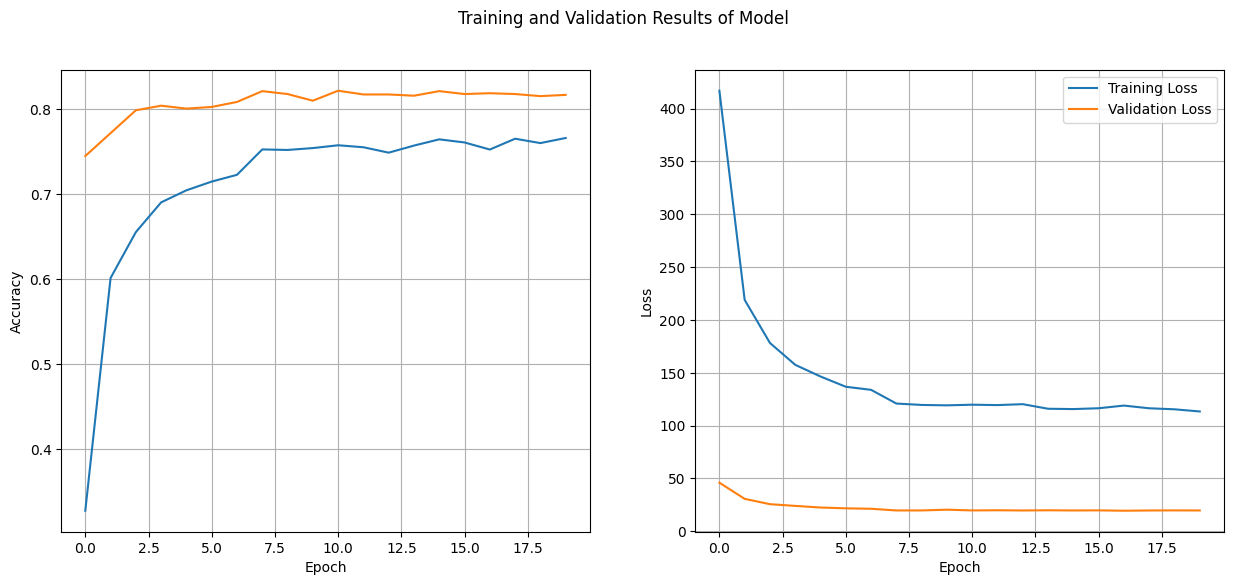

In [21]:
# Training and Validation Results
fig, axs = plt.subplots(1,2, figsize=(15,6))
axs[0].plot(range(20), history[0], label="Training accuracy")
axs[0].plot(range(20), history[2], label="Validation accuracy")
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].grid(True)

axs[1].plot(range(20), history[1], label="Training Loss")
axs[1].plot(range(20), history[3], label="Validation Loss")
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].grid(True)

plt.suptitle("Training and Validation Results of Model")
plt.legend()
plt.show()

# Submission

## Read test data

In [22]:
test_data = pd.DataFrame([])
for dirname, _, filename in os.walk('/kaggle/input/dog-breed-identification/test/'):
    filename = pd.Series(filename)
    test_data = pd.concat([test_data, filename], axis=0)
test_data.columns = ['id']
test_data['id'] = test_data['id'].str.replace(".jpg","")

In [23]:
# Dataset shape
print(f"Test dataset shape: {test_data.shape}")
# Sample of the train_data DataFrame
test_data.head()

Test dataset shape: (10357, 1)


,id
0,09e51e17e2b756ff2ace8a87bd1443fa
1,f7a32505c12649183c5991ecfa7d68b3
2,bc6d50ffb4644feb34530aa58943e85b
3,7cbc041e79135a572aad87904b5c9c57
4,f3b603f10d6a344f0395fb46b242ff8e


## Get Test Data Loader

In [24]:
test_dataset = Dog_Breed_Dataset(
    df=test_data,
    img_base_path='/kaggle/input/dog-breed-identification/test/',
    split='test',
    transforms=test_transforms
)

test_dl = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

In [25]:
def test_model(test_dl, model):       
              
        # Predictions DataFrame
        prob_preds = pd.DataFrame([])
        
        for x in test_dl:
            # Convert data to Tensor            
            x = x.clone().detach().to(device)            
            # Predict
            pred = model(x)  
            prob_pred = T.nn.functional.softmax(pred, dim=1)
            
            prob_pred = prob_pred.detach().cpu().numpy()             
            prob_pred = pd.DataFrame(prob_pred)
            
            prob_preds = pd.concat([prob_preds, prob_pred], axis=0)            
            
        return prob_preds            

In [26]:
test_preds = test_model(test_dl, model)
test_preds.shape

(10357, 120)

In [27]:
test_preds.head()

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,3.513018e-06,3.716062e-07,7.029108e-06,0.000001,0.087586,0.000004,0.000013,0.000029,0.000002,0.000017,...,6.788420e-06,2.655246e-05,4.131984e-07,0.000007,2.023749e-07,5.112056e-07,1.837610e-05,0.000036,1.706850e-05,0.000011
1,2.581076e-07,1.240007e-06,1.119417e-07,0.000003,0.000011,0.000002,0.000005,0.000041,0.000298,0.000012,...,8.845394e-07,8.801275e-07,5.070171e-03,0.000041,1.208459e-06,9.045381e-06,4.597178e-07,0.000003,5.657867e-07,0.000002
2,2.583967e-05,7.642888e-03,2.455542e-04,0.000143,0.000095,0.000090,0.000067,0.000026,0.000039,0.000011,...,3.641715e-05,2.484339e-05,6.118880e-06,0.000049,2.074762e-05,1.684926e-04,3.733837e-05,0.000193,2.577295e-05,0.000029
3,8.745271e-07,1.530462e-06,1.641686e-06,0.000004,0.000284,0.000018,0.000002,0.000079,0.000006,0.000002,...,1.291144e-06,1.760888e-04,5.175715e-06,0.000009,2.596547e-03,2.121726e-06,5.745485e-06,0.082510,7.584276e-05,0.000002
4,2.080206e-07,4.765839e-06,1.283123e-06,0.000002,0.000004,0.000025,0.000006,0.000017,0.001529,0.000025,...,8.575544e-07,2.647484e-06,3.322776e-06,0.000311,4.671598e-07,9.901260e-01,2.972615e-06,0.000003,2.201551e-05,0.000001


In [28]:
# Set columns to breed names
num_classes = []
for num_class in test_preds.columns:
    num_classes.append(num_class)

num_classes = np.array(num_classes)
num_classes = le.inverse_transform(num_classes)
test_preds.columns = list(num_classes)

In [29]:
test_preds.head()

,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,beagle,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,3.513018e-06,3.716062e-07,7.029108e-06,0.000001,0.087586,0.000004,0.000013,0.000029,0.000002,0.000017,...,6.788420e-06,2.655246e-05,4.131984e-07,0.000007,2.023749e-07,5.112056e-07,1.837610e-05,0.000036,1.706850e-05,0.000011
1,2.581076e-07,1.240007e-06,1.119417e-07,0.000003,0.000011,0.000002,0.000005,0.000041,0.000298,0.000012,...,8.845394e-07,8.801275e-07,5.070171e-03,0.000041,1.208459e-06,9.045381e-06,4.597178e-07,0.000003,5.657867e-07,0.000002
2,2.583967e-05,7.642888e-03,2.455542e-04,0.000143,0.000095,0.000090,0.000067,0.000026,0.000039,0.000011,...,3.641715e-05,2.484339e-05,6.118880e-06,0.000049,2.074762e-05,1.684926e-04,3.733837e-05,0.000193,2.577295e-05,0.000029
3,8.745271e-07,1.530462e-06,1.641686e-06,0.000004,0.000284,0.000018,0.000002,0.000079,0.000006,0.000002,...,1.291144e-06,1.760888e-04,5.175715e-06,0.000009,2.596547e-03,2.121726e-06,5.745485e-06,0.082510,7.584276e-05,0.000002
4,2.080206e-07,4.765839e-06,1.283123e-06,0.000002,0.000004,0.000025,0.000006,0.000017,0.001529,0.000025,...,8.575544e-07,2.647484e-06,3.322776e-06,0.000311,4.671598e-07,9.901260e-01,2.972615e-06,0.000003,2.201551e-05,0.000001


In [30]:
# Set id column
test_preds = test_preds.reset_index(drop=True)
ids = test_data.loc[:,'id']
test_preds = pd.concat([ids, test_preds], axis=1)
test_preds.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,09e51e17e2b756ff2ace8a87bd1443fa,3.513018e-06,3.716062e-07,7.029108e-06,0.000001,0.087586,0.000004,0.000013,0.000029,0.000002,...,6.788420e-06,2.655246e-05,4.131984e-07,0.000007,2.023749e-07,5.112056e-07,1.837610e-05,0.000036,1.706850e-05,0.000011
1,f7a32505c12649183c5991ecfa7d68b3,2.581076e-07,1.240007e-06,1.119417e-07,0.000003,0.000011,0.000002,0.000005,0.000041,0.000298,...,8.845394e-07,8.801275e-07,5.070171e-03,0.000041,1.208459e-06,9.045381e-06,4.597178e-07,0.000003,5.657867e-07,0.000002
2,bc6d50ffb4644feb34530aa58943e85b,2.583967e-05,7.642888e-03,2.455542e-04,0.000143,0.000095,0.000090,0.000067,0.000026,0.000039,...,3.641715e-05,2.484339e-05,6.118880e-06,0.000049,2.074762e-05,1.684926e-04,3.733837e-05,0.000193,2.577295e-05,0.000029
3,7cbc041e79135a572aad87904b5c9c57,8.745271e-07,1.530462e-06,1.641686e-06,0.000004,0.000284,0.000018,0.000002,0.000079,0.000006,...,1.291144e-06,1.760888e-04,5.175715e-06,0.000009,2.596547e-03,2.121726e-06,5.745485e-06,0.082510,7.584276e-05,0.000002
4,f3b603f10d6a344f0395fb46b242ff8e,2.080206e-07,4.765839e-06,1.283123e-06,0.000002,0.000004,0.000025,0.000006,0.000017,0.001529,...,8.575544e-07,2.647484e-06,3.322776e-06,0.000311,4.671598e-07,9.901260e-01,2.972615e-06,0.000003,2.201551e-05,0.000001


In [31]:
test_preds.to_csv('submission.csv', index=None)